# HW1: Solve differential equation using the Chubby Chef's Method :)

The equation asked to solve is:

\begin{equation}
\ddot{u}+ a \dot{u} + b u= f(t)
\end{equation}
where $t= [0;1]$, $u(0)=1$, $\dot{u}(0)=0$


We were asked to test the accuracy and provide different possible dynamics out of that equation. I would like to mention that I mostly made use of the functions and pieces of code provided in class.


In [450]:
import numpy as np
from matplotlib import pyplot
pyplot.style.use('ggplot')

#These functions were taken from the class notes and left untouched:

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (np.cos(np.linspace(-np.pi, 0, n)))

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

def chebeval(z, n=None):
    z = np.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = np.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = np.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]
    

In [404]:
#These functions were taken from the class notes, but this
#time I modified them to suit the problem better:

def laplacian_cheb(a,b, n, rhsfunc, diri, neum):
    
    t = cosspace(-1, 1, 2*n+1)  #Based on my interpretation of prof's remark about open domain Chubby Chef
    # I originally tried to define t between 0 and 1 and then shift T to be in 2*t-1 but then faced some complications
    
    T = np.array(chebeval(t))
 
    L= T[2]+a*T[1]+b*T[0]
    rhs = rhsfunc(t)
    
    #I don't know if this is right, but when I tried to implement Neumann at t=0, it did not play well with the other IC. 
    for i,deriv,func in [(n, *diri), (n+1, *neum)]:
        L[i] = T[deriv][i]
        rhs[i] = func(t[i])
    
    return t, L.dot(np.linalg.inv(T[0])), rhs

#I know this does not matter that much, but I designed my solution to be a function that follows the ICs per se. 
class exact_cos:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return np.cos(x)

    def du(self, x):
        return -np.sin(x)
 
    def ddu(self, x):
        return -np.cos(x)

   
       

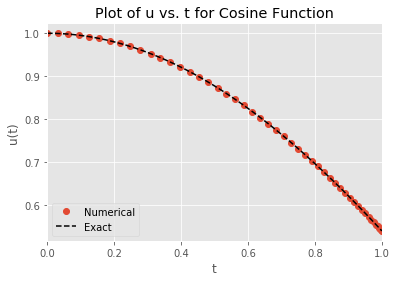

In [422]:
a=1
b=1
n=50

x= np.array(np.linspace(0, 1, n+1))
ex = exact_cos()

t, L, rhs = laplacian_cheb(a,b, n, lambda t: ex.ddu(t)+a*ex.du(t)+b*ex.u(t), diri=(0,ex.u), neum=(1,ex.du))

pyplot.figure()
pyplot.plot(t, np.linalg.solve(L, rhs), 'o', label= "Numerical")
pyplot.plot(x, ex.u(x), '--k',label= "Exact");
pyplot.xlim([0,1])
pyplot.xlabel("t")
pyplot.ylabel("u(t)")
pyplot.title("Plot of u vs. t for Cosine Function")
pyplot.legend(loc='lower left');
pyplot.show()


## Task 1. Investigate Accuracy

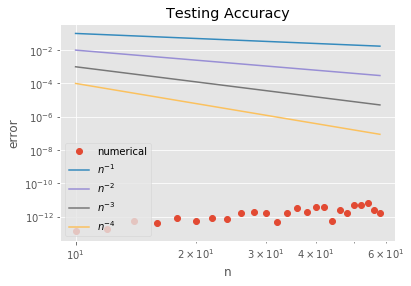

In [451]:
# Using functions from the Lecture notes:

def mms_error (n, a, b):
        t, L, rhs = laplacian_cheb(a,b, n, lambda t: ex.ddu(t)+a*ex.du(t)+b*ex.u(t), diri=(0,ex.u), neum=(1,ex.du))
        calc= np.linalg.solve(L,rhs)
        return np.linalg.norm(calc[n:]-ex.u(t)[n:], np.inf)


ns= np.arange(10,60,2)
errors = [mms_error(n, a, b) for n in ns]
pyplot.figure()
pyplot.loglog(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')  
pyplot.legend(loc='lower left');
pyplot.title('Testing Accuracy')
pyplot.show()
    

Unfortunately, I could not devise a method whose error decayed with n. 

## Task 2. f(x) =0, find different regimes given by values of a and b

\begin{equation}
\ddot{u}+ a \dot{u} + b u= f(t)
\end{equation}
where $t= [0;1]$, $u(0)=1$, $\dot{u}(0)=0$

The first possible dynamic regime that I could find at f(x)=0 was for a=0 and b being any value. This means that the first derivative or "damping term" is gone. This can translate into a "mass and spring with no external force" situation.

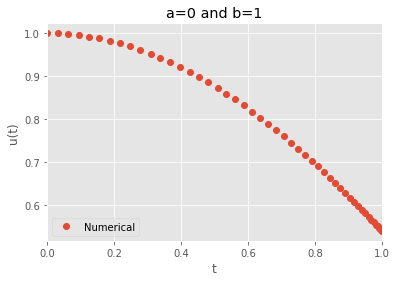

In [441]:
a=0
b=1
n=50

x= np.array(np.linspace(0, 1, n+1))
ex = exact_cos()

t, L, rhs = laplacian_cheb(a,b, n, lambda t: 0*t, diri=(0,ex.u), neum=(1,ex.du))

pyplot.figure()
pyplot.plot(t, np.linalg.solve(L, rhs), 'o', label= "Numerical")
pyplot.xlim([0,1])
pyplot.xlabel("t")
pyplot.ylabel("u(t)")
pyplot.title("a=0 and b=1")
pyplot.legend(loc='lower left');
pyplot.show()

There is a tradeoff between the dampening of a and the oscillatory tendency of b as t-> inf. One can realize that if I increase b to 200 and leave a as 1, my motion will start being more oscillatory. 

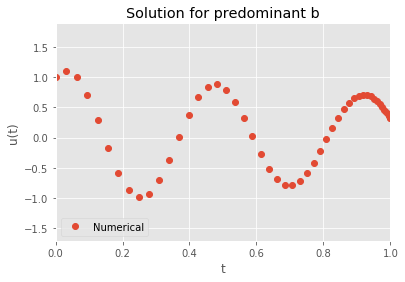

In [452]:
a=1
b=200
n=50

x= np.array(np.linspace(0, 1, n+1))
ex = exact_cos()

t, L, rhs = laplacian_cheb(a,b, n, lambda t: 0*t, diri=(0,ex.u), neum=(1,ex.du))

pyplot.figure()
pyplot.plot(t, np.linalg.solve(L, rhs), 'o', label= "Numerical")
pyplot.xlim([0,1])
pyplot.xlabel("t")
pyplot.ylabel("u(t)")
pyplot.title("Solution for predominant b")
pyplot.legend(loc='lower left');
pyplot.show()

However, if what I want is a decay or equilibrium in time, a predominant 'a' will provide me that.

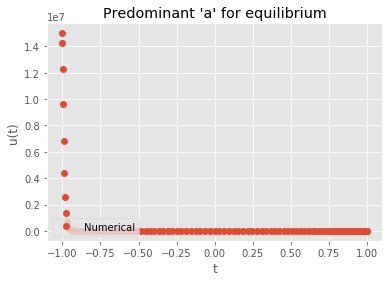

In [453]:
a=100
b=0
n=50

x= np.array(np.linspace(0, 1, n+1))
ex = exact_cos()

t, L, rhs = laplacian_cheb(a,b, n, lambda t: 0*t, diri=(0,ex.u), neum=(1,ex.du))

pyplot.figure()
pyplot.plot(t, np.linalg.solve(L, rhs), 'o', label= "Numerical")
pyplot.xlabel("t")
pyplot.ylabel("u(t)")
pyplot.title("Predominant 'a' for equilibrium")
pyplot.legend(loc='lower left');
pyplot.show()

For predominant a's, our system seems to find an equilibrium point.